In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import time
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

# Suppress a specific warning
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
base_url = "https://www.realclearpolling.com/polls/"
sample_url = "president/republican-primary/2024/national"
sample_url = "president/general/2024/trump-vs-biden"
url = base_url + sample_url

In [3]:
# Create a webdriver instance and get the page source
driver = webdriver.Chrome()
driver.get(url)

# Allow time for dynamic content to load (you may need to adjust the sleep duration)
time.sleep(3)

# Get the page source after dynamic content has loaded
html_content = driver.page_source

# Close the webdriver
driver.quit()

# Parse the HTML content with BeautifulSoup
soup = BeautifulSoup(html_content, 'html5lib')

# Now you can extract the table data using the same approach as before
table = soup.find_all('table')

if len(table)==2:
    table = table[1]
else:
    table = table[0]

table_data = []
for row in table.find_all('tr'):
    row_data = [cell.text.strip() for cell in row.find_all(['td','th'])]
    table_data.append(row_data)

In [4]:
#Convert table data to a dataframe
#We remove the first row since this is RCP summary data that we don't want to use

current_year = str(datetime.now().year)
prev_year = str(datetime.now().year-1)


df = pd.DataFrame(table_data[2:150], columns=table_data[0])
df["Difference"] = df["Trump (R)"].astype(float) - df["Biden (D)"].astype(float)
df["Type of Voter"] = df["sample"].str.split(" ").str[1]
df["Sample Size"] = df["sample"].str.split(" ").str[0]
#We need to add the year to the date to make it a datetime object
#We need to make sure the year we add is the year the poll was taken, not necessarily the current year
df["End Date"] = df["date"].str.split("-").str[1] 
df["Poll Month"] = df["date"].str.split("-").str[1].str.split("/").str[0]
df["Poll Month"] = df["Poll Month"].astype(int)
first_dec = df[df["Poll Month"]==12].index[0]
df["Year"] = [current_year]*first_dec + [prev_year]*(len(df)-first_dec)
df["End Date"] = df["End Date"] + "/" + df["Year"]
df["End Date"] = np.array(pd.to_datetime(df["End Date"], format="mixed"))
df = df[df["Type of Voter"].isin(["RV", "LV"])]
df.head()

,pollster,date,sample,moe,Trump (R),Biden (D),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year
0,CNN,1/25 - 1/30,1212 RV,3.4,49,45,Trump+4,4.0,RV,1212,2024-01-30,1,2024
1,Quinnipiac,1/25 - 1/29,1650 RV,2.4,44,50,Biden+6,-6.0,RV,1650,2024-01-29,1,2024
2,Yahoo News,1/25 - 1/29,1069 RV,—,45,44,Trump+1,1.0,RV,1069,2024-01-29,1,2024
3,Emerson,1/26 - 1/29,1260 RV,2.7,46,45,Trump+1,1.0,RV,1260,2024-01-29,1,2024
4,Economist/YouGov,1/28 - 1/30,1486 RV,2.9,42,43,Biden+1,-1.0,RV,1486,2024-01-30,1,2024


In [5]:


# Assuming df is your DataFrame with time series data
# Make sure the DataFrame has a column with datetime values

# Create a simple time series chart using plotly express
fig = px.scatter(df, x='End Date', y='Difference', trendline= "ols", title='Trump Biden Spread',
              labels={'value_column': 'Y-axis Label', 'datetime_column': 'X-axis Label'},
              color = 'Type of Voter',
                hover_data=['pollster', 'Sample Size'],
              template='seaborn', width=1000, height=600
              )
fig.show()

## LV vs. RVs Time Series Analysis

Also adjust for who is taking the poll/bias. Plus recency weighted bias. 
Predict spread based on LV vs. RV, date, and polling company. Work with ARIMA model, with dummy variables for polling companies.
Baseline prediction could be realclear spread at that time. And then we can compare whether the spread is better or worse than our prediction. 

Look for differences between Joe Biden Voters and Liberal Voters, as well as Trump Voters and Conservative voters. Has anything changed?

Difference between overall favorability, and job approval.

Compare likely to vote for, vs. past voting.

Mean Squared Error: 9.029766610168478


/Users/robbiefeldstein/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/robbiefeldstein/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/robbiefeldstein/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/robbiefeldstein/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



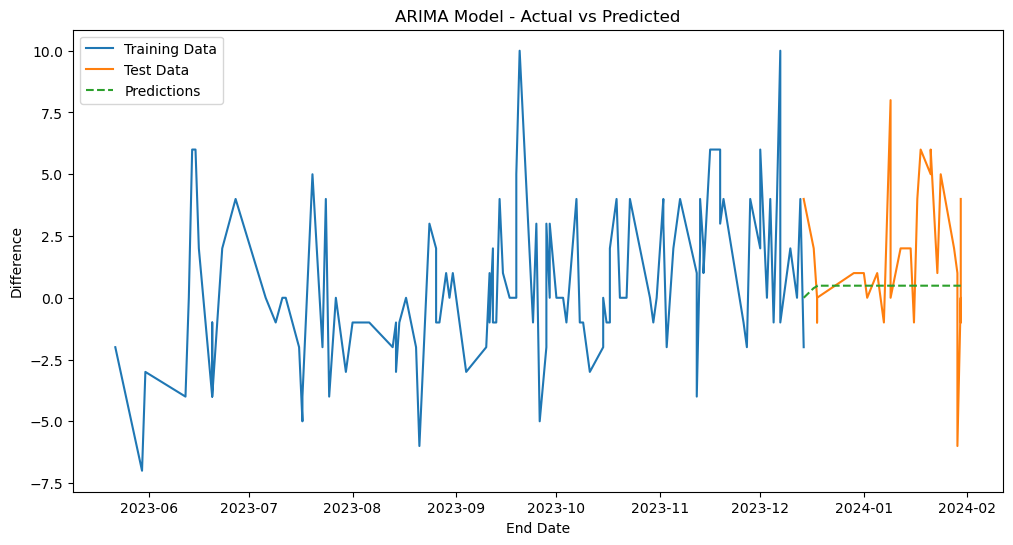

In [6]:
#Time Series Modeling (ARIMA)

#Spread = Poll Company + Type of Voter + Date + Sample Size?

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

ndf = df.copy()


ndf.set_index('End Date', inplace=True)
ndf.sort_index(inplace=True)

# Train-Test Split
train_size = int(len(ndf) * 0.8)
train, test = ndf[:train_size], ndf[train_size:]

# ARIMA Model
order = (1, 0, 0)  # Set appropriate values for p, d, q
model = ARIMA(train['Difference'], order=order)
fit_model = model.fit()

# Model Prediction
predictions = fit_model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Model Evaluation
mse = mean_squared_error(test['Difference'], predictions)
print(f'Mean Squared Error: {mse}')

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Difference'], label='Training Data')
plt.plot(test.index, test['Difference'], label='Test Data')
plt.plot(test.index, predictions, label='Predictions', linestyle='dashed')

plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('End Date')
plt.ylabel('Difference')
plt.legend()
plt.show()


In [7]:
#Need to figure out how to get the pollster in here

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor



ndf = df.copy()
ndf["Year"] = ndf["End Date"].dt.year
ndf["Month"] = ndf["End Date"].dt.month
ndf["Day"] = ndf["End Date"].dt.day

# Feature selection
features = ['Type of Voter', 'Sample Size', 'pollster', 'Year', 'Month', 'Day']
X = ndf[features]
y = ndf['Difference']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use OneHotEncoder for categorical variables and keep numeric variables as is
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Type of Voter']),
        ('num', 'passthrough', ['Sample Size', 'Year', 'Month', 'Day'])
    ])

# Create a pipeline with preprocessing and regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor())])

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')




Mean Squared Error: 5.164013205958607


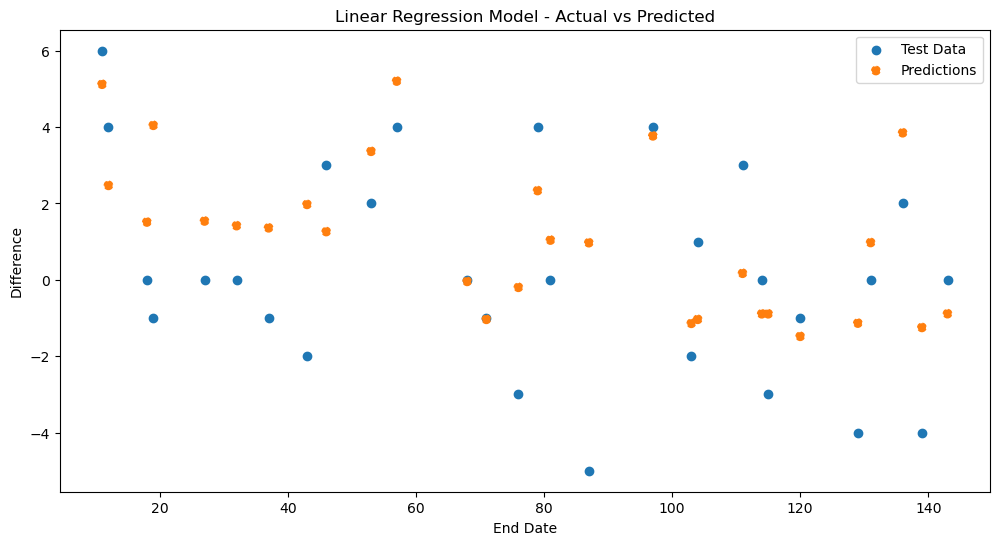

In [8]:
#plot the above model

plt.figure(figsize=(12, 6))
plt.scatter(X_test.index, y_test, label='Test Data')
plt.scatter(X_test.index, predictions, label='Predictions', linestyle='dashed')

plt.title('Linear Regression Model - Actual vs Predicted')

plt.xlabel('End Date')

plt.ylabel('Difference')

plt.legend()
plt.show()


# RFK Junior Polls

In [9]:
#Load in the Wikipedia table data

url = "https://en.wikipedia.org/wiki/Nationwide_opinion_polling_for_the_2024_United_States_presidential_election" 
driver = webdriver.Chrome()

driver.get(url)

# Allow time for dynamic content to load (you may need to adjust the sleep duration)
time.sleep(3)

# Get the page source after dynamic content has loaded
html_content = driver.page_source

# Close the webdriver
driver.quit()

# Parse the HTML content with BeautifulSoup

soup = BeautifulSoup(html_content, 'html5lib')

# Now you can extract the table data using the same approach as before
table_dat = soup.find_all('table')

table = table_dat[10]


In [10]:
table_data = []
for row in table.find_all('tr'):
    row_data = [cell.text.strip() for cell in row.find_all(['td','th'])]
    table_data.append(row_data)

#Convert table data to a dataframe
#We remove the first row since this is RCP summary data that we don't want to use
    
df = pd.DataFrame(table_data[1:], columns=table_data[0])
df.head()


,Poll source,Date,Samplesize[b],Marginof error,JoeBidenDemocratic,DonaldTrumpRepublican,Robert F.Kennedy Jr.Independent,Other/Undecided
0,Reuters/Ipsos,"January 3–9, 2024","4,677 (RV)",± 1.5%,29%,30%,18%,23%
1,Quinnipiac University,"December 14–18, 2023","1,647 (RV)",± 2.4%,38%,36%,22%,4%
2,Rasmussen Reports,"December 6–7 & 10, 2023",892 (LV),± 3.0%,32%,40%,16%,12%[j]
3,Cygnal (R),"December 5–7, 2023","2,000 (LV)",± 2.16%,42%,43%,9%,6%
4,Harvard/Harris,"November 15–16, 2023","2,851 (RV)",–,36%,44%,21%,0%


In [11]:
#Time Series Plot of Wikipedia Data

df["Year"] = df["Date"].str.split(" ").str[-1]
df["Month"] = df["Date"].str.split(" ").str[0]
df["Day"] = df["Date"].str.split(" ").str[1].str.split("–").str[0]
df["New Date"] = df["Month"] + " " + df["Day"] + ", " + df["Year"]
df["New Date"] = pd.to_datetime(df["New Date"],format="mixed")
df['JoeBidenDemocratic'] = df['JoeBidenDemocratic'].str.rstrip('%').astype('float') / 100
df['DonaldTrumpRepublican'] = df['DonaldTrumpRepublican'].str.rstrip('%').astype('float') / 100
df["Robert F.Kennedy Jr.Independent"] = df["Robert F.Kennedy Jr.Independent"].str.rstrip('%').astype('float') / 100
df.set_index("New Date", inplace=True)
df.drop("2023-10-09", inplace=True)
df["Spread"] = df["DonaldTrumpRepublican"] - df["JoeBidenDemocratic"]
df.head()

,Poll source,Date,Samplesize[b],Marginof error,JoeBidenDemocratic,DonaldTrumpRepublican,Robert F.Kennedy Jr.Independent,Other/Undecided,Year,Month,Day,Spread
New Date,,,,,,,,,,,,
2024-01-03,Reuters/Ipsos,"January 3–9, 2024","4,677 (RV)",± 1.5%,0.29,0.30,0.18,23%,2024,January,3,0.01
2023-12-14,Quinnipiac University,"December 14–18, 2023","1,647 (RV)",± 2.4%,0.38,0.36,0.22,4%,2023,December,14,-0.02
2023-12-06,Rasmussen Reports,"December 6–7 & 10, 2023",892 (LV),± 3.0%,0.32,0.40,0.16,12%[j],2023,December,6,0.08
2023-12-05,Cygnal (R),"December 5–7, 2023","2,000 (LV)",± 2.16%,0.42,0.43,0.09,6%,2023,December,5,0.01
2023-11-15,Harvard/Harris,"November 15–16, 2023","2,851 (RV)",–,0.36,0.44,0.21,0%,2023,November,15,0.08


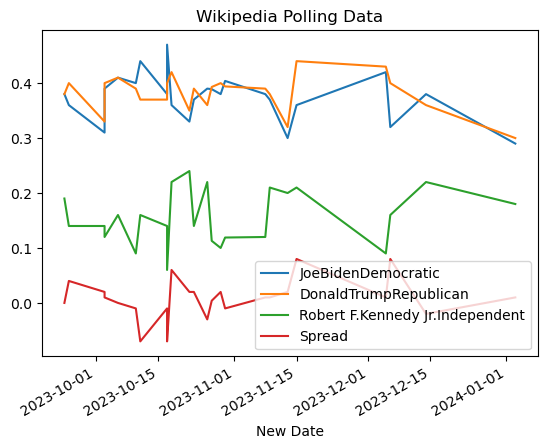

In [12]:
df.plot()
plt.title('Wikipedia Polling Data')
plt.show()

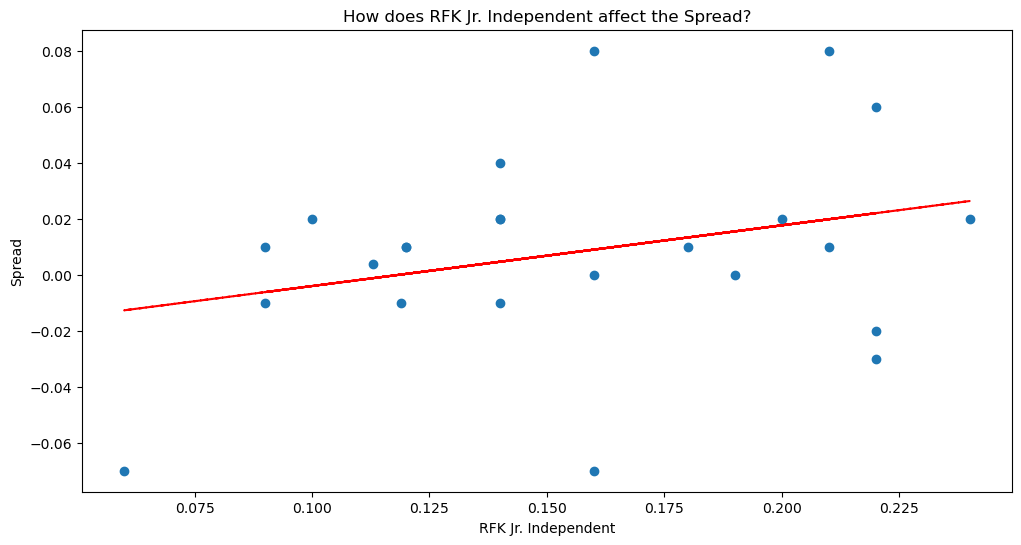

In [21]:
#Time Series Analysis of Wikipedia Data

#Plot RFK Jr. Independent vs. Spread

plt.figure(figsize=(12, 6))
plt.scatter(df["Robert F.Kennedy Jr.Independent"], df["Spread"])
#plt.scatter(df.index, df["Robert F.Kennedy Jr.Independent"], label='RFK Jr. Independent', linestyle='dashed')

#Add trendline
z = np.polyfit(df["Robert F.Kennedy Jr.Independent"], df["Spread"], 1)
p = np.poly1d(z)
plt.plot(df["Robert F.Kennedy Jr.Independent"],p(df["Robert F.Kennedy Jr.Independent"]),"r--")


plt.title('How does RFK Jr. Independent affect the Spread?')
plt.xlabel('RFK Jr. Independent')
plt.ylabel('Spread')
plt.show()